# <font color='red'>듀란듀란팀</font>의 <font color='blue'>자전거 수요예측</font>!!!

## <font color='black'>Description</font>
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
- - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals
- Evaluation

## <font color='black'>Evaluation</font>
- <font color='red'>자전거 대여량</font>을 예측하는 <font color='blue'>회귀</font>와 관련된 문제!

In [1]:
## import pandas as pd
from datetime import datetime
import pandas as pd
import time
import numpy as np
import re
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats
from matplotlib import font_manager, rc

# font_name = font_manager.FontProperties(fname="/Library/Fonts/AppleGothic.ttf").get_name()
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/MALGUN.TTF").get_name()
rc('font', family=font_name)
# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

C:\Python\Anaconda3-52\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_train = pd.read_csv('./data/bikesharing_train.csv',parse_dates=["datetime"],encoding = 'utf-8')
df_train.shape

(10886, 12)

In [3]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 상관계수&시각화를 통해 feature 조정

In [4]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour
df_train.shape

(10886, 16)

In [5]:
df_train.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
season,1.0,0.029,-0.0081,0.0089,0.26,0.26,0.19,-0.15,0.097,0.16,0.16,-0.0048,0.97,0.0017,-0.0065
holiday,0.029,1.0,-0.25,-0.0071,0.00029,-0.0052,0.0019,0.0084,0.044,-0.021,-0.0054,0.012,0.0017,-0.016,-0.00035
workingday,-0.0081,-0.25,1.0,0.034,0.03,0.025,-0.011,0.013,-0.32,0.12,0.012,-0.0025,-0.0034,0.0098,0.0028
weather,0.0089,-0.0071,0.034,1.0,-0.055,-0.055,0.41,0.0073,-0.14,-0.11,-0.13,-0.013,0.012,-0.0079,-0.023
temp,0.26,0.00029,0.03,-0.055,1.0,0.98,-0.065,-0.018,0.47,0.32,0.39,0.061,0.26,0.016,0.15
atemp,0.26,-0.0052,0.025,-0.055,0.98,1.0,-0.044,-0.057,0.46,0.31,0.39,0.059,0.26,0.012,0.14
humidity,0.19,0.0019,-0.011,0.41,-0.065,-0.044,1.0,-0.32,-0.35,-0.27,-0.32,-0.079,0.2,-0.011,-0.28
windspeed,-0.15,0.0084,0.013,0.0073,-0.018,-0.057,-0.32,1.0,0.092,0.091,0.1,-0.015,-0.15,0.036,0.15
casual,0.097,0.044,-0.32,-0.14,0.47,0.46,-0.35,0.092,1.0,0.5,0.69,0.15,0.093,0.014,0.3
registered,0.16,-0.021,0.12,-0.11,0.32,0.31,-0.27,0.091,0.5,1.0,0.97,0.26,0.17,0.019,0.38


In [6]:
del df_train["casual"]
del df_train["registered"]
del df_train["season"]
del df_train['atemp']

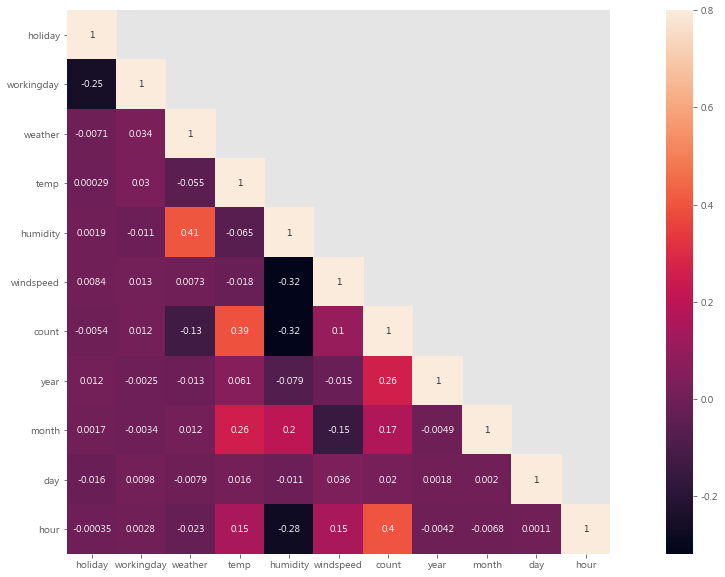

In [7]:
mask = np.array(df_train.corr()) 
mask[np.tril_indices_from(mask)] = False 
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(df_train.corr(), mask=mask,vmax=.8, square=True,annot=True)

[Text(0.5,0,'hour'), Text(0.5,1,'시간별 대여량')]

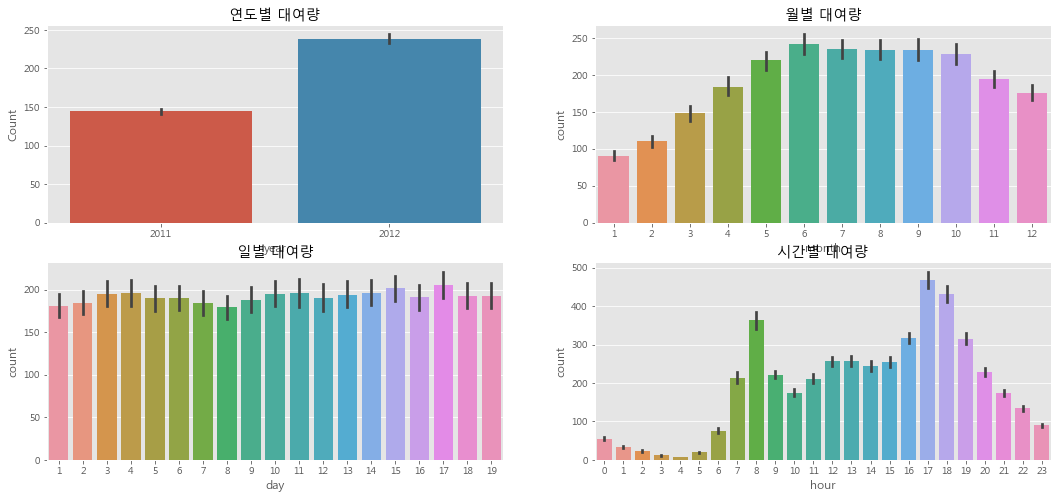

In [8]:
import seaborn as sns
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,8)

sns.barplot(data=df_train, x="year", y="count", ax=ax1)
sns.barplot(data=df_train, x="month", y="count", ax=ax2)
sns.barplot(data=df_train, x="day", y="count", ax=ax3)
sns.barplot(data=df_train, x="hour", y="count", ax=ax4)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")


- 연도별 자전거 대여량 2011 < <font color='red'>2012</font>
- 월별 자전거 대여량은 < <font color='red'>6월</font>에 가장 많고 7~10월도 대여량이 많다. 그리고 <font color='blue'>1월</font>에 가장 적다.
- 일별자전거 대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 
  그래서 이 데이터를 가지고 바로 학습시킬 수는 없음.
- 시간 대 대여량을 보면 <font color='red'>출퇴근 시간</font>에 대여량이 많은 것 같다.

In [9]:
max(df_train['count']),min(df_train['count'])

(977, 1)

In [10]:
# trainWithoutOutliers
df_trainWithoutOutliers = df_train[np.abs(df_train["count"] - df_train["count"].mean()) <= (3*df_train["count"].std())]

print(df_train.shape) #outlier 제거 전
print(df_trainWithoutOutliers.shape) #outlier제거 후 

(10886, 12)
(10739, 12)


## 풍속 결측치 조정

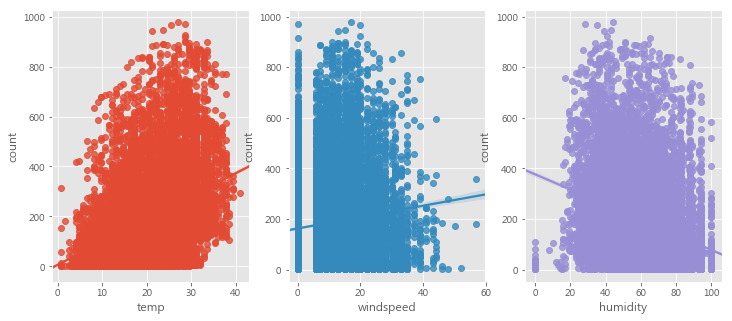

In [11]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=df_train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=df_train,ax=ax2)
sns.regplot(x="humidity", y="count", data=df_train,ax=ax3)

- 풍속의 경우 0에 숫자가 몰려 있는 것을 볼 수 있음
- 결측치라는 것을 알 수 있음

In [12]:
# windspeed가 0인 결측값이 존재!!! 
df_trainWithoutOutliers['windspeed'].value_counts().head()

0.0000     1297
8.9981     1109
11.0014    1037
7.0015     1027
12.9980    1027
Name: windspeed, dtype: int64

In [13]:
# 풍속이 0인것과 아닌 것의 세트 나누기
trainWind0 = df_trainWithoutOutliers.loc[df_trainWithoutOutliers['windspeed'] == 0]
trainWindNot0 = df_trainWithoutOutliers.loc[df_trainWithoutOutliers['windspeed'] != 0]

In [14]:
del trainWind0['windspeed']

In [15]:
# 결측값 갯수 총 1297개
len(trainWind0)

1297

In [16]:
# 결측값을 채워넣기 위해 trainWindNot0을 이용해 랜덤값을 뽑자!!!
wind=np.random.normal(trainWindNot0['windspeed'].mean(), 1, 1297)
df_wind=pd.DataFrame(wind)
df_wind=df_wind.rename(columns={0:'windspeed'})
df_wind.head()

,windspeed
0,13.489756
1,13.959769
2,14.147881
3,16.047230
4,13.115909


In [17]:
trainWind0 = trainWind0.reset_index(drop=True)
trainWind0.columns

Index(['datetime', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
       'count', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [18]:
trainWind0 = pd.concat([trainWind0,df_wind],axis = 1)
trainWind0.head()

,datetime,holiday,workingday,weather,temp,humidity,count,year,month,day,hour,windspeed
0,2011-01-01 00:00:00,0,0,1,9.84,81,16,2011,1,1,0,13.489756
1,2011-01-01 01:00:00,0,0,1,9.02,80,40,2011,1,1,1,13.959769
2,2011-01-01 02:00:00,0,0,1,9.02,80,32,2011,1,1,2,14.147881
3,2011-01-01 03:00:00,0,0,1,9.84,75,13,2011,1,1,3,16.047230
4,2011-01-01 04:00:00,0,0,1,9.84,75,1,2011,1,1,4,13.115909


In [19]:
train_all = pd.concat([trainWind0, trainWindNot0], axis=0)

C:\Python\Anaconda3-52\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [20]:
train_all=train_all[[ 'holiday', 'workingday', 'weather', 'temp', 
        'humidity', 'windspeed', 'year', 'month',
       'day', 'hour', 'count']]
train_all.head()

,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,count
0,0,0,1,9.84,81,13.489756,2011,1,1,0,16
1,0,0,1,9.02,80,13.959769,2011,1,1,1,40
2,0,0,1,9.02,80,14.147881,2011,1,1,2,32
3,0,0,1,9.84,75,16.047230,2011,1,1,3,13
4,0,0,1,9.84,75,13.115909,2011,1,1,4,1


# 다른 feature 값들 정규화

In [21]:
# train_all
train_all['year'] =train_all['year'] -2011
train_all['year']

train_all.head()

,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,count
0,0,0,1,9.84,81,13.489756,0,1,1,0,16
1,0,0,1,9.02,80,13.959769,0,1,1,1,40
2,0,0,1,9.02,80,14.147881,0,1,1,2,32
3,0,0,1,9.84,75,16.047230,0,1,1,3,13
4,0,0,1,9.84,75,13.115909,0,1,1,4,1


In [22]:
train_all.describe()

,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,count
count,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000
mean,0.028960,0.676786,1.420710,20.130507,62.049632,14.544969,0.495111,6.505354,9.983239,11.479281,183.003818
std,0.167702,0.467726,0.634956,7.777571,19.241364,6.665407,0.499999,3.456491,5.477795,6.931510,166.681429
min,0.000000,0.000000,1.000000,0.820000,0.000000,6.003200,0.000000,1.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000,13.940000,47.000000,8.998100,0.000000,4.000000,5.000000,6.000000,41.000000
50%,0.000000,1.000000,1.000000,20.500000,62.000000,13.827928,0.000000,6.000000,10.000000,11.000000,141.000000
75%,0.000000,1.000000,2.000000,26.240000,78.000000,16.997900,1.000000,10.000000,15.000000,17.000000,276.000000
max,1.000000,1.000000,4.000000,41.000000,100.000000,56.996900,1.000000,12.000000,19.000000,23.000000,734.000000


In [23]:
train_all.to_csv('./data/듀란이들의bike_copy1.csv', sep=',', encoding='utf-8')

# <font color='red'>Learning</font> by <font color='blue'>doing</font>, <font color='blue'>Doing</font> by <font color='red'>learning!</font>

In [24]:
from tqdm import tqdm_notebook
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [33]:
import tensorflow as tf
import numpy as np

tf.set_random_seed(777)  # for reproducibility

# np.loadtxt('./data/test2_bike.csv', delimiter=',', dtype=np.float32)
xy = np.loadtxt('./data/듀란이들의bike_copy1.csv', delimiter=',', skiprows=1, dtype=np.int32)
x_data = xy[:, 1:-1]
y_data = xy[:, [-1]]

# Make sure the shape and data are OK
print("x_data.shape : {}, \tlen(x_data) : {} \nx_data : \n{}".format(x_data.shape, len(x_data), x_data))
print("-"*25)
print("y_data.shape : {}  \ny_data : \n{}".format(y_data.shape, y_data))

# placeholders for a tensor that will be always fed.
X = tf.placeholder(tf.float32, shape=[None, 10])
Y = tf.placeholder(tf.float32, shape=[None, 1])

W1 = tf.Variable(tf.random_normal([10, 128]), name='weight')
b1 = tf.Variable(tf.random_normal([128]), name='bias')
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

# W2 = tf.Variable(tf.random_normal([128, 128]), name='weight2')
# b2 = tf.Variable(tf.random_normal([128]), name='bias2')
# L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W2 = tf.Variable(tf.random_normal([128, 1]))
b2 = tf.Variable(tf.random_normal([1]))

# Hypothesis
hypothesis = tf.matmul(L1, W2) + b2

# Simplified cost/loss function
cost = tf.reduce_mean(tf.square(hypothesis - Y))

# Minimize
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-5)
train = optimizer.minimize(cost)


x_data.shape : (10739, 10), 	len(x_data) : 10739 
x_data : 
[[ 0  0  1 ...  1  1  0]
 [ 0  0  1 ...  1  1  1]
 [ 0  0  1 ...  1  1  2]
 ...
 [ 0  1  1 ... 12 19 21]
 [ 0  1  1 ... 12 19 22]
 [ 0  1  1 ... 12 19 23]]
-------------------------
y_data.shape : (10739, 1)  
y_data : 
[[ 16]
 [ 40]
 [ 32]
 ...
 [168]
 [129]
 [ 88]]


In [ ]:
# Launch the graph in a session.
sess = tf.Session()
# Initializes global variables in the graph.
sess.run(tf.global_variables_initializer())

for step in tqdm_notebook(range(10001)):
    cost_val, hy_val, t_val = sess.run(
        [cost, hypothesis, train], feed_dict={X: x_data, Y: y_data})

    if step % 100 == 0 or step < 100 : 
        print("\nStep : {} \nCost : {} \nPrediction :\n{}".format(step, cost_val, t_val))
        print("Step : {} \tCost : {} ".format(step, cost_val))
        


Step : 0 
Cost : 658690.1875 
Prediction :
None
Step : 0 	Cost : 658690.1875 

Step : 1 
Cost : 70634784.0 
Prediction :
None
Step : 1 	Cost : 70634784.0 

Step : 2 
Cost : 31682.19921875 
Prediction :
None
Step : 2 	Cost : 31682.19921875 

Step : 3 
Cost : 28469.03515625 
Prediction :
None
Step : 3 	Cost : 28469.03515625 

Step : 4 
Cost : 26670.853515625 
Prediction :
None
Step : 4 	Cost : 26670.853515625 

Step : 5 
Cost : 25732.96484375 
Prediction :
None
Step : 5 	Cost : 25732.96484375 

Step : 6 
Cost : 25180.8359375 
Prediction :
None
Step : 6 	Cost : 25180.8359375 

Step : 7 
Cost : 24778.380859375 
Prediction :
None
Step : 7 	Cost : 24778.380859375 

Step : 8 
Cost : 24443.59375 
Prediction :
None
Step : 8 	Cost : 24443.59375 

Step : 9 
Cost : 24147.4140625 
Prediction :
None
Step : 9 	Cost : 24147.4140625 

Step : 10 
Cost : 23878.46484375 
Prediction :
None
Step : 10 	Cost : 23878.46484375 

Step : 11 
Cost : 23631.53125 
Prediction :
None
Step : 11 	Cost : 23631.53125 

S

Step : 94 	Cost : 19290.625 

Step : 95 
Cost : 19278.048828125 
Prediction :
None
Step : 95 	Cost : 19278.048828125 

Step : 96 
Cost : 19265.806640625 
Prediction :
None
Step : 96 	Cost : 19265.806640625 

Step : 97 
Cost : 19253.83203125 
Prediction :
None
Step : 97 	Cost : 19253.83203125 

Step : 98 
Cost : 19242.080078125 
Prediction :
None
Step : 98 	Cost : 19242.080078125 

Step : 99 
Cost : 19230.443359375 
Prediction :
None
Step : 99 	Cost : 19230.443359375 

Step : 100 
Cost : 19218.8984375 
Prediction :
None
Step : 100 	Cost : 19218.8984375 

Step : 200 
Cost : 18578.912109375 
Prediction :
None
Step : 200 	Cost : 18578.912109375 

Step : 300 
Cost : 18270.341796875 
Prediction :
None
Step : 300 	Cost : 18270.341796875 

Step : 400 
Cost : 18084.388671875 
Prediction :
None
Step : 400 	Cost : 18084.388671875 
